<a href="https://colab.research.google.com/github/michalinahulak/lunar_landscape_segmentation/blob/main/Lunar_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install kaggle

In [ ]:
pip install segmentation-models-pytorch

In [ ]:
!pip install -U neptune

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import cv2
import random

from sklearn.model_selection import train_test_split

from PIL import Image

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn as nn

import segmentation_models_pytorch as smp
import neptune

# Functions

In [ ]:
H = 128
W = 128

class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transforms.Compose([
            transforms.Resize((H, W)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        mask_path = self.mask_paths[index]

        # Load image
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # Load mask
        mask = Image.open(mask_path).convert('RGB')
        mask = self.transform(mask)

        return img, mask


def load_data(X_dir, y_dir, batch_size=32, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((H, W)),
    ])

    X = [os.path.join(X_dir, x) for x in sorted(os.listdir(X_dir))]
    y = [os.path.join(y_dir, x) for x in sorted(os.listdir(y_dir))]

    dataset = CustomDataset(X, y)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

# Upload dataset

In [ ]:
#upload your kaggle.json file

from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d romainpessia/artificial-lunar-rocky-landscape-dataset

100% 5.02G/5.02G [03:12<00:00, 32.0MB/s]
100% 5.02G/5.02G [03:12<00:00, 28.0MB/s]


In [ ]:
#unzip 
zip_file_path = '/content/artificial-lunar-rocky-landscape-dataset.zip'
extract_dir = '/content/dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("File has been extracted.")

File has been extracted.


# Load data

In [ ]:
RENDER_IMAGE_DIR_PATH = '/content/dataset/images/render'
GROUND_MASK_DIR_PATH = '/content/dataset/images/ground'

train_loader, test_loader = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(train_loader.dataset)} \n Test: {len(test_loader.dataset)}")

Dataset:
 Train: 7812 
 Test: 1954


# EDA

In [ ]:
# Tensor shape of image and mask
image, mask = train_loader.dataset[0]
print('Tensor shape of image: ', image.shape)
print('Tensor shape of mask: ', mask.shape)

Tensor sape of image:  torch.Size([3, 128, 128])
Tensor shape of mask:  torch.Size([3, 128, 128])


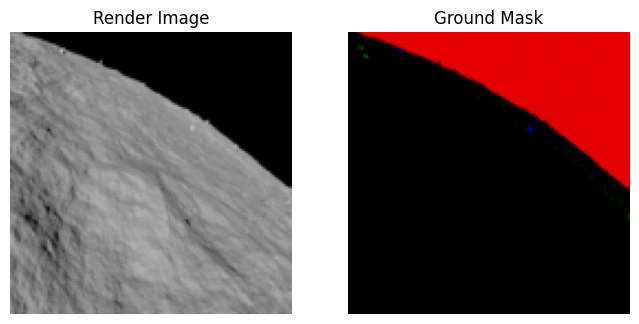

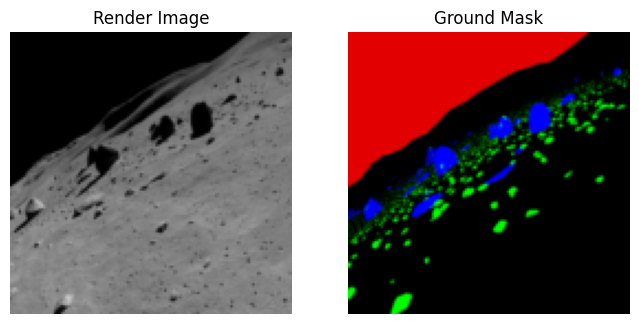

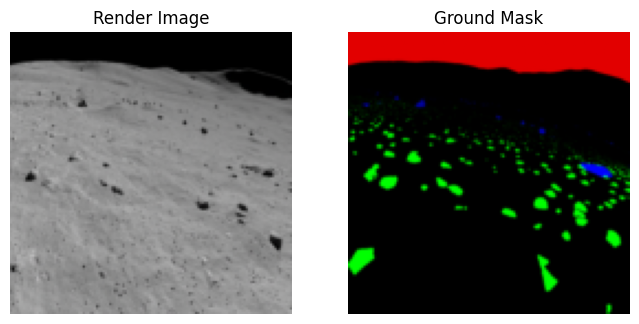

In [ ]:
# 3 random images from tain dataset
random_indices = random.sample(range(len(train_loader.dataset)), 3)

for index in random_indices:
    image, mask = train_loader.dataset[index]

    image = image.numpy().transpose(1, 2, 0)
    mask = mask.numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(image)
    axes[0].set_title("Render Image")
    axes[0].axis("off")
    axes[1].imshow(mask)
    axes[1].set_title("Ground Mask")
    axes[1].axis("off")

    plt.show()

# Transfer learning

In [ ]:
from getpass import getpass

my_api_token = getpass("Enter your Neptune API token: ")

Enter your Neptune API token: ··········


In [ ]:
my_project = "michalinahulak/lunar-landscape"

In [ ]:
run = neptune.init_run(
    project=my_project,
    api_token=my_api_token,
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

https://app.neptune.ai/michalinahulak/lunar-landscape/e/LUN-4


In [ ]:
# Przypisanie metadanych do run
run["parameters"] = {
    "encoder_name": "resnet50",
    "encoder_weights": "imagenet",
    "in_channels": 3,
    "classes": 4,
    "lr": 0.001,
    "epochs": 3,
}

model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=3
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
epochs = 3
for epoch in range(epochs):
    # Ustalenie modelu w trybie treningowym
    model.train()

    # Inicjalizacja wartości bieżącej straty
    running_loss = 0.0

    # Iteracja po danych treningowych
    for images, masks in train_loader:
        # Przeniesienie danych na urządzenie (CPU lub GPU)
        images = images.to(device)
        masks = masks.to(device)

        # Wyzerowanie gradientów
        optimizer.zero_grad()

        # Przekazanie danych przez model
        outputs = model(images)

        # Obliczenie straty
        loss = criterion(outputs, masks)

        # Propagacja wsteczna i aktualizacja wag
        loss.backward()
        optimizer.step()

        # Aktualizacja bieżącej straty
        running_loss += loss.item() * images.size(0)

    # Obliczenie straty treningowej na epokę
    epoch_loss = running_loss / len(train_loader.dataset)

    # Ustalenie modelu w trybie ewaluacji (bez obliczania gradientów)
    model.eval()

    # Inicjalizacja wartości straty walidacyjnej
    val_loss = 0.0

    # Wyłączenie obliczania gradientów i propagacji wstecznej dla danych walidacyjnych
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)

    # Obliczenie straty walidacyjnej na epokę
    epoch_val_loss = val_loss / len(test_loader.dataset)

    # Logowanie metryk do Neptune
    run["train/loss"].log(epoch_loss)
    run["val/loss"].log(epoch_val_loss)

    # Wyświetlanie informacji o epoce
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# Zakończenie run Neptune
run.stop()

Epoch: 1/3, Loss: 0.0511, Val Loss: 0.0455
Epoch: 2/3, Loss: 0.0389, Val Loss: 0.0566
Epoch: 3/3, Loss: 0.0345, Val Loss: 0.0392
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 5 operations to synchronize with Neptune. Do not kill this process.
All 5 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/michalinahulak/lunar-landscape/e/LUN-4/metadata


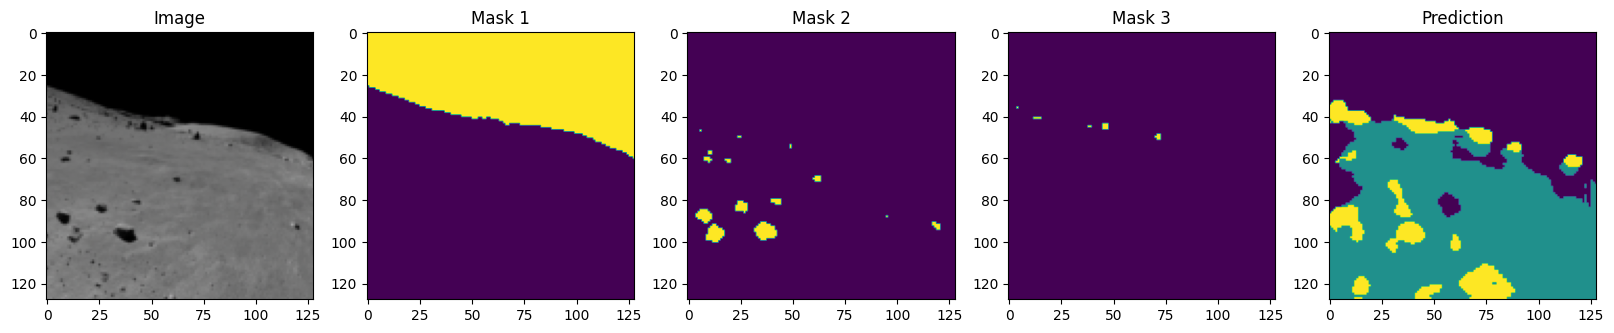

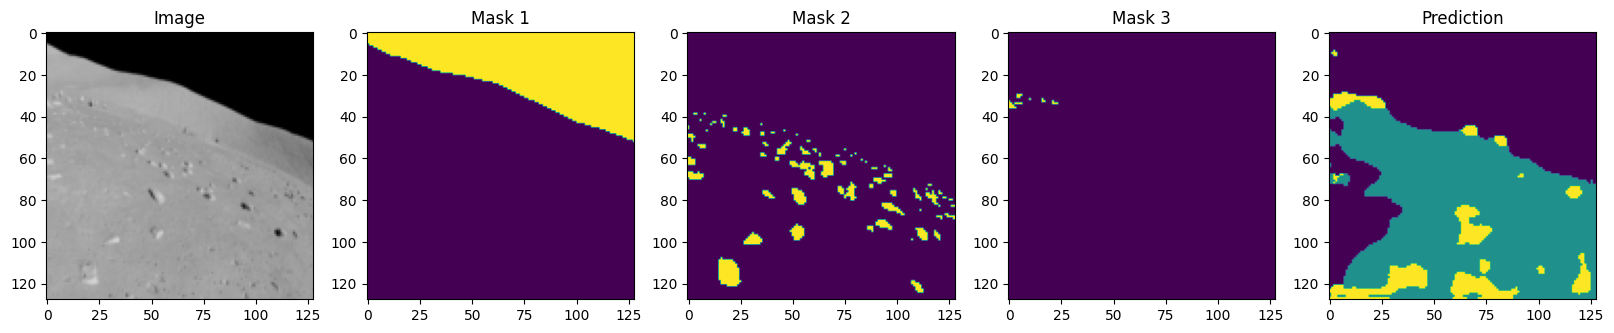

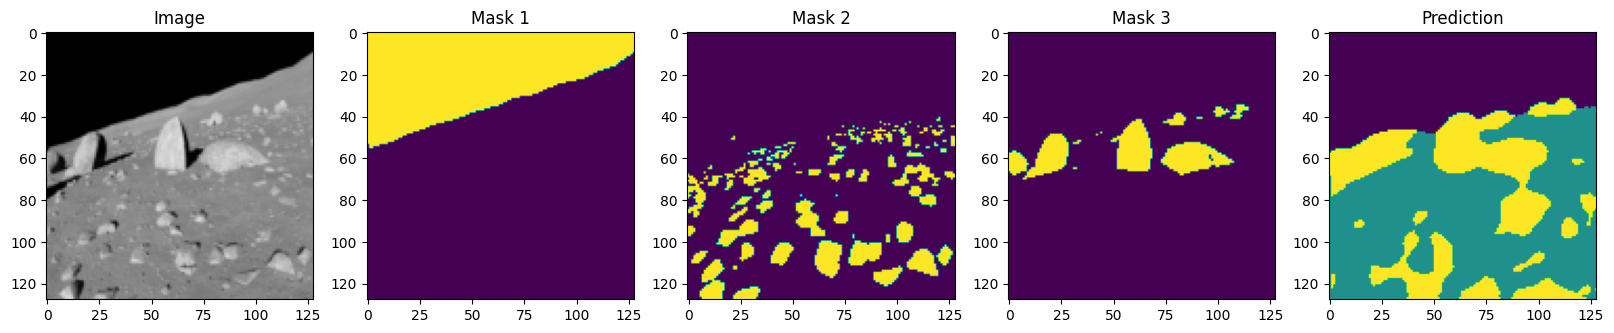

In [ ]:
model.eval()

random_indices = random.sample(range(len(test_loader.dataset)), 3)

for index in random_indices:
    image, mask = test_loader.dataset[index]

    # Przenosimy dane na urządzenie (CPU lub GPU)
    image = image.to(device)
    mask = mask.to(device)

    # Generujemy predykcję modelu dla wybranego zdjęcia
    prediction = model(image.unsqueeze(0))

    mask_threshold = 0.4  # Próg do przekształcenia maski

    # Przekształcenie maski na etykiety klas
    mask = (mask >= mask_threshold).type(torch.uint8)

    # Przekształcenie predykcji na wartości prawdopodobieństwa
    prediction = torch.softmax(prediction, dim=1).squeeze().cpu().detach().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].imshow(image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[1].imshow(mask[0])
    axes[1].set_title('Mask 1')
    axes[2].imshow(mask[1])
    axes[2].set_title('Mask 2')
    axes[3].imshow(mask[2])
    axes[3].set_title('Mask 3')
    axes[4].imshow(prediction.argmax(axis=0))
    axes[4].set_title('Prediction')

    plt.show()